In [1]:
from LRL import *

In [2]:
USE_CUDA

True

In [ ]:
class MyBufferAgent(ReplayBufferAgent):  # TODO check if sumtree works faster
    """
    Experimental
    """
    __doc__ += ReplayBufferAgent.__doc__ 
      
    def __init__(self, config):
        super().__init__(config)
        
        self.true_reward_to_go = np.array([])
        self.priorities = np.array([])
        self.logger_labels["median weight"] = ("training iteration", "median weight")

    def memorize_transition(self, state, action, reward, next_state, done):
        # new transition is stored with max priority
        if len(self) < self.config.replay_buffer_capacity:
            self.priorities = np.append(self.priorities, 1)
            self.true_reward_to_go = np.append(self.true_reward_to_go, reward)
        else:
            self.priorities[self.pos] = 1
            self.true_reward_to_go[self.pos] = reward
            
        super().memorize_transition(state, action, reward, next_state, done)

    def sample(self, batch_size):
        # proposed weights for sampling
        probs  = np.array(self.priorities)
        probs /= probs.sum()
        
        self.batch_indices = np.random.choice(len(self), batch_size, p=probs, replace=True)   # do not use replace = False, it makes O(n)
        samples = [self.buffer[idx] for idx in self.batch_indices] # seems like the fastest code for sampling!
        
        # calculating importance sampling weights to evade bias
        # these weights are annealed to be more like uniform at the beginning of learning
        #weights  = (probs[self.batch_indices]) ** (-self.rp_beta_by_frame(self.frames_done))
        # these weights are normalized as proposed in the original article to make loss function scale more stable.
        #weights /= (probs.min()) ** (-self.rp_beta_by_frame(self.frames_done))
       
        states, actions, rewards, next_states, dones = zip(*samples)
        #self.logger["median weight"].append(np.median(weights))
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones, np.ones((batch_size))#weights

    def update_priorities(self, batch_priorities):
        """
        Updates priorities for previously sampled batch, indexes stored in self.batch_indices
        input: batch_priorities - np.array, floats, (batch_size)
        """
        diff = self.q_values.detach().cpu().numpy() - self.true_reward_to_go[self.batch_indices]
        self.priorities[self.batch_indices] = 4 / (2 + np.exp(diff) + np.exp(-diff))
        
    def see(self, state, action, reward, next_state, done):
        if len(self.buffer) > 0:        
            for g in range(state.shape[0]):
                t = (self.pos - (state.shape[0] - g)) % min(self.config.replay_buffer_capacity, len(self.buffer))
                discount = self.config.gamma
                while not self.buffer[t][4]:        # what if training was reset?
                    self.true_reward_to_go[t] += discount * reward[g]
                    discount *= self.config.gamma
                    
                    t = (t - self.env.num_envs) % min(self.config.replay_buffer_capacity, len(self.buffer))
                    
                    if (t == (self.pos - (state.shape[0] - g)) % min(self.config.replay_buffer_capacity, len(self.buffer))):
                        break
        
        super().see(state, action, reward, next_state, done)
            
    #def write_memory(self, mem_f):
    #    super().write_memory(mem_f)
    #    pickle.dump(self.priorities, mem_f)
    #    
    #def read_memory(self, mem_f):
    #    super().read_memory(mem_f)
    #    self.priorities = pickle.load(mem_f)


# Cartpole task

In [3]:
env = gym.make('CartPole-v0')

In [4]:
class CartpoleNN(nn.Module):
    def __init__(self, linear):
        super().__init__()
        
        self.layers = nn.Sequential(
                        linear(4, 128),
                        nn.ReLU(),
                        linear(128, 128),
                        nn.ReLU())
        
    def forward(self, x):
        return self.layers(x)

In [5]:
config = {
    "env": env,
    "Qnetwork_FeatureExtractor": CartpoleNN,
    "QnetworkHead": Qnetwork,
    "batch_size": 32,
    "gamma": 0.99,
    "replay_buffer_init": 128,
    "replay_buffer_capacity": 1000,
    "epsilon_start": 1, "epsilon_final": 0.01, "epsilon_decay": 500
}

In [6]:
agent = eGreedy((QAgent(MyBufferAgent)))(config)

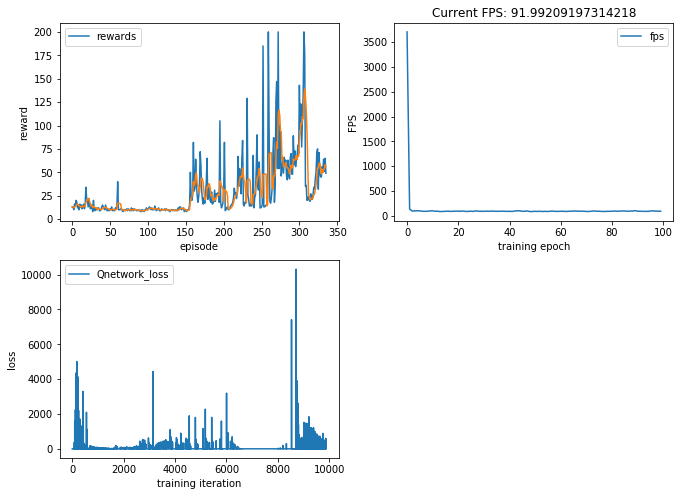

In [7]:
for i in range(100):
    agent.learn(100)
    plot_durations(agent, 5)    

plt.show()

In [8]:
agent.true_reward_to_go

array([13.99416454, 13.12541872, 12.2478977 , 11.36151283, 10.46617457,
        9.5617925 ,  8.64827525,  7.72553056,  6.79346521,  5.85198506,
        4.90099501,  3.940399  ,  2.9701    ,  1.99      ,  1.        ,
       23.76572857, 22.99568542, 22.21786406, 21.43218592, 20.63857164,
       19.83694105, 19.02721318, 18.20930624, 17.38313762, 16.54862385,
       15.70568066, 14.85422289, 13.99416454, 13.12541872, 12.2478977 ,
       11.36151283, 10.46617457,  9.5617925 ,  8.64827525,  7.72553056,
        6.79346521,  5.85198506,  4.90099501,  3.940399  ,  2.9701    ,
        1.99      ,  1.        , 19.02721318, 18.20930624, 17.38313762,
       16.54862385, 15.70568066, 14.85422289, 13.99416454, 13.12541872,
       12.2478977 , 11.36151283, 10.46617457,  9.5617925 ,  8.64827525,
        7.72553056,  6.79346521,  5.85198506,  4.90099501,  3.940399  ,
        2.9701    ,  1.99      ,  1.        , 19.02721318, 18.20930624,
       17.38313762, 16.54862385, 15.70568066, 14.85422289, 13.99

In [10]:
agent.priorities.max()

8.757964480156327e-10